# Get images and labels from 'data' folder

## Dataset class:

In [20]:
#https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
# main imports:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import torchvision.transforms.v2 as v2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

#set parameters:
torch.manual_seed(100)
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)

#define dataset to be used in loader
class BacteriaDataset(Dataset):
    def __init__(self, annotations:pd.Series, images:pd.Series,transform = None, device = None ):
        self.img_labels = annotations
        self.images = images
        self.transform = transform
        self.to_tensor_transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])  
        self.device = device

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        label = self.img_labels.iloc[idx]
        
        img_path = self.images.iloc[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        if type(img) is not torch.Tensor:
            img = self.to_tensor_transform(img)
        img = img.to(self.device)
        return img, label

BacteriaDataset defintion done


## Split data: - <ins> sklearn shuffle = False </ins>

In [6]:
#read and prepare data
image_anots = pd.read_csv('data/bacteria_species.csv')
image_dir = 'data/bac_images'
image_anots['image_path'] = image_dir +"/"+ image_anots['image_name']

#convert str categories to integers
ordinal_enc = OrdinalEncoder(dtype=int) # assigns each category to an int
image_anots['encoded_cats'] = ordinal_enc.fit_transform(pd.DataFrame(image_anots['label_name']))

#split data into train and test sets
train_data, test_data = train_test_split(image_anots,test_size=0.25,shuffle=False,random_state=100)

In [7]:
image_size = 2048
batch_size = 10

img = Image.open('data/bac_images/sp01_img01.jpg').convert('RGB')
t = v2.Compose([
    v2.Resize([image_size,image_size]),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    v2.Normalize(mean=[0.0550, 0.0316, 0.0273],std=[0.0206, 0.0259, 0.0257]),
    ])  
img_t = t(img)
print('done')

done


## Dataloaders & datasets - <ins> torch shuffle = True </ins>

In [18]:
# means from RGB channels, calculated in data_stats_calc.ipynb
pixel_means = [0.0550, 0.0316, 0.0273]
pixel_stds = [0.0206, 0.0259, 0.0257]

transform = v2.Compose([
    v2.Resize([image_size,image_size]),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    v2.Normalize(pixel_means,pixel_stds),
    ])

train_dataset = BacteriaDataset(annotations=train_data['encoded_cats'],images=train_data['image_path'],transform=transform,device=device)
test_dataset = BacteriaDataset(annotations=test_data['encoded_cats'],images=test_data['image_path'],transform=transform,device=device)

train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

for images, labels in train_dataloader:
    print(f'Batch shape: {images.shape}')
    print(f'Labels shape: {labels.shape}')
    break

train_features, train_labels = next(iter(train_dataloader))
print(train_features.shape)
print(train_labels.shape)
test_features, train_features = next(iter(test_dataloader))
print('done')

BacteriaDataset: is "img" a tensor?: True
img device: mps:0
BacteriaDataset: is "img" a tensor?: True
img device: mps:0
BacteriaDataset: is "img" a tensor?: True
img device: mps:0
BacteriaDataset: is "img" a tensor?: True
img device: mps:0
BacteriaDataset: is "img" a tensor?: True
img device: mps:0
BacteriaDataset: is "img" a tensor?: True
img device: mps:0
BacteriaDataset: is "img" a tensor?: True
img device: mps:0
BacteriaDataset: is "img" a tensor?: True
img device: mps:0
BacteriaDataset: is "img" a tensor?: True
img device: mps:0
BacteriaDataset: is "img" a tensor?: True
img device: mps:0
Batch shape: torch.Size([10, 3, 2048, 2048])
Labels shape: torch.Size([10])
BacteriaDataset: is "img" a tensor?: True
img device: mps:0
BacteriaDataset: is "img" a tensor?: True
img device: mps:0
BacteriaDataset: is "img" a tensor?: True
img device: mps:0
BacteriaDataset: is "img" a tensor?: True
img device: mps:0
BacteriaDataset: is "img" a tensor?: True
img device: mps:0
BacteriaDataset: is "img

## Visualize images in `BacteriaDataset`

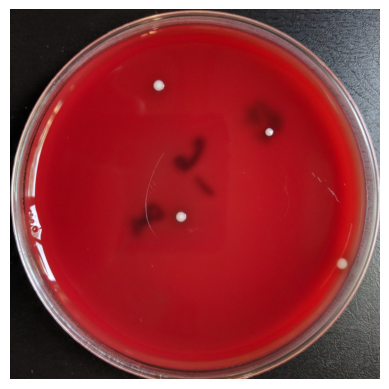

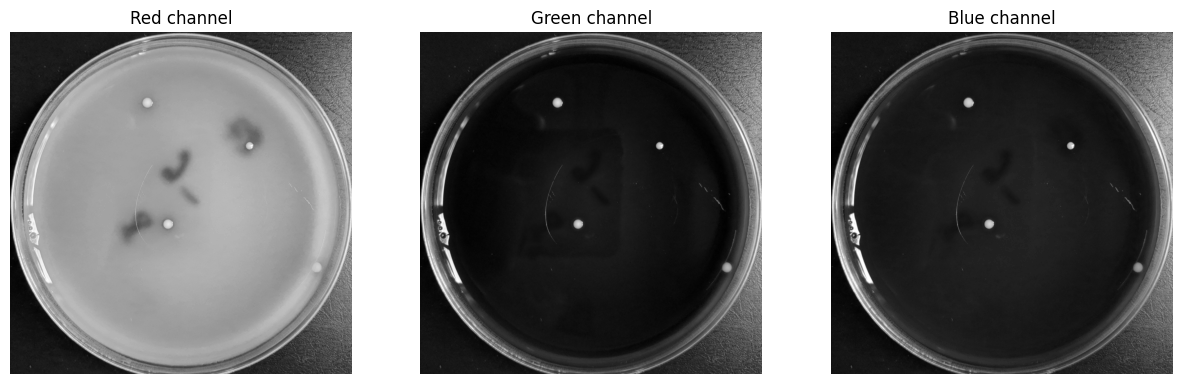

done


In [47]:
import matplotlib.pyplot as plt
import numpy as np

viz_transform = v2.Compose([
    v2.Resize([image_size,image_size]),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    ])

viz_train_dataset = BacteriaDataset(annotations=train_data['encoded_cats'],images=train_data['image_path'],transform=viz_transform) 
viz_train_dataloader = DataLoader(viz_train_dataset,batch_size=batch_size,shuffle=False,)


def visualize_image_tensor(tensor):
    # Convert the tensor to a numpy array
    img = tensor.permute(1, 2, 0).numpy()  # Convert to [height, width, channels]
    img = np.clip(img, 0, 1)  # Ensure pixel values are in [0, 1] range

    # Plot the image
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.show()

def visualize_channels(tensor):
    channels = tensor.size(1)
    channel_names = ['Red','Green','Blue']
    fig, axes = plt.subplots(1, channels, figsize=(15, 5))
    for i in range(channels):
        ax = axes[i]
        img = tensor[0, i].numpy()  # First image, i-th channel
        ax.imshow(img, cmap='gray')
        ax.set_title(f'{channel_names[i]} channel')
        ax.axis('off')
    plt.show()

# Example usage within the DataLoader loop
for images, labels in viz_train_dataloader:
    # Visualize random image - because of dataloader shuffle
    visualize_image_tensor(images[0])
    visualize_channels(images)

    break

print('done')